# Lab 4: Supervised classification using handcrafted features


In this lab we will classify pool tiles to detect which ones are upside-down during the manufacturing process.




## Goals
In this lab, you will:
- Extract hand-crafted features from images
- Classify pool tiles with multiple classifers to detect which ones are upside-down during the manufacturing process
- Compare the classifers and choose the best one

In this Notebook we are going to compare the classifiers you used in the previous labs. Like in the previous labs, we will use Python library "scikit-learn", especifically the functions [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html), [RandomForest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), [Support Vector Machine](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) and [XGBoost](https://xgboost.readthedocs.io/en/latest/python/python_intro.html) .

First of all, we are provided a folder that contains two different datasets of tiles (each dataset contains training, validation and testing image sets). Initially, the images are as follows:

<div>
<img src="https://drive.google.com/uc?export=view&id=1fagQmuBpR-PJxyZ87BB5yk50k2_BMHz4" width="700"/>
</div>


However, to make it easier, the datasets are not from these images, but rather from each tile, to which we applied a homography (i.e. a planar transformation) to get an orthogonal view of each tile. <br>
<div>
<img src= "https://drive.google.com/uc?export=view&id=1HlhdjNY79pVh6e8ONckXUhP645svHPDf" width="600"/>
</div>

Each image set contains two classes of tiles: tiles that are upside-down, where the texture is rather rough, and tiles that are upright, where the texture is normally smoother, but there may be some lines, highlights and/or shadows in some of them.

<div>
<img src="https://drive.google.com/uc?export=view&id=1qsgaD04DQuS08IXnw8egC7RZkPmldN2q" width="700"/>
</div>


The objective is, as we said at the beginning, to classify these tiles as upright or upside-down. For that, the features of each image must be computed.

## Dataset
Before extracting the features, we first need to know which datasets we have. All the datasets provided have the same structure:

<div>
<img src="https://drive.google.com/uc?export=view&id=1kRug51OZzF3MQP9UyBHhVSloTxPQbAkZ" width="700"/>
</div>

Essentially, the only difference between each dataset is the number of images per set:<br>

<ul>
<li>	Dataset (0) <b> “200-100-100” </b> contains:</li>
    <ul>
    <li> 200 images for training: </li>
      <ul>
        <li> 100 images of upright tiles </li>
        <li> 100 images if upside-down tiles</li>
      </ul>
    <li> 100 images for validation:</li>
      <ul>
        <li> 50 images of upright tiles</li>
        <li> 50 images of upside-down tiles</li>
      </ul>
    <li>100 images for testing: </li>
      <ul>
        <li> 50 images of upright tiles</li>
        <li> 50 images of upside-down tiles</li>
      </ul>
    </ul>
  <li>Dataset (1) <b> “1000-200-200” </b> contains:</li>
    <ul>
    <li> 1000 images for training: </li>
      <ul>
        <li> 500 images of upright tiles </li>
        <li> 500 images if upside-down tiles</li>
      </ul>
    <li> 200 images for validation:</li>
      <ul>
        <li> 100 images of upright tiles</li>
        <li> 100 images of upside-down tiles</li>
      </ul>
    <li>200 images for testing: </li>
      <ul>
        <li> 100 images of upright tiles</li>
        <li> 100 images of upside-down tiles</li>
      </ul>
    </ul>
  <li>Dataset (2) <b> “10000-2000-2000” </b> contains:</li>
    <ul>
    <li> 1000 images for training: </li>
      <ul>
        <li> 5000 images of upright tiles </li>
        <li> 5000 images if upside-down tiles</li>
      </ul>
    <li> 2000 images for validation:</li>
      <ul>
        <li> 1000 images of upright tiles</li>
        <li> 1000 images of upside-down tiles</li>
      </ul>
    <li>2000 images for testing: </li>
      <ul>
        <li> 1000 images of upright tiles</li>
        <li> 1000 images of upside-down tiles</li>
      </ul>
    </ul>
  



In [ ]:
import numpy as np
import cv2
from os import listdir
from os.path import isfile, join
import os
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern, hog
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from scipy.special import expit
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import seaborn as sns
from google.colab import drive

Now we are going to load the datasets and extract images path.
First, you need to add the datasets into your drive. Open [this link](https://drive.google.com/drive/folders/1TBwh3woRWa2dAUJ_N40uwdSoSSETItPA?usp=sharing) and right click on the folder name "Lab_07_Tiles" and select "Add shortcut to Drive".
Next we load the dataset as follow:

In [ ]:
#loading the dataset from Drive
drive.mount('/content/drive')
data_path = '/content/drive/MyDrive/CV Week 4/Lab_07_datasets'

#Dataset (0):  Define paths of train, validation and test dataset folder which contain the images for dataset "200-100-100"
train_path_d0 ='/content/drive/MyDrive/CVWeek4/Lab_07_datasets/200-100-100/train'
validation_path_d0 ='/content/drive/MyDrive/CVWeek4/Lab_07_datasets/200-100-100/validation'
test_path_d0 ='/content/drive/MyDrive/CVWeek4/Lab_07_datasets/200-100-100/test'

#Dataset (1):  Define paths of train, validation and test dataset folder which contain the images for dataset "1000-200-200"
train_path_d1 = '/content/drive/MyDrive/CVWeek4/Lab_07_datasets/1000-200-200/train'
validation_path_d1 = '/content/drive/MyDrive/CVWeek4/Lab_07_datasets/1000-200-200/validation'
test_path_d1 ='/content/drive/MyDrive/CVWeek4/Lab_07_datasets/1000-200-200/test'



Mounted at /content/drive


## Feature extraction

To classify images, we first need some features to pass to the classifier.
We refer as “feature” a distinctive attribute or aspect of the image.

The first part of this lab is to compute the features of all images in the three image sets: train, validation and test. For that, we are going to try one function from the Scikit-Image library to compute these features:

- `hog()`

Let's learn a bit more about these features that we will extract from the images: <br>
•	<b> hog() </b>: <br>
The histogram of oriented gradients (HOG) is a feature descriptor used in computer vision and image processing for the purpose of object detection. The technique counts occurrences of gradient orientation in localized portions of an image. The essential thought behind the histogram of oriented gradients descriptor is that local object appearance and shape within an image can be described by the distribution of intensity gradients or edge directions. The image is divided into small, connected regions called cells, and for the pixels within each cell, a histogram of gradient directions is compiled. The descriptor is the concatenation of these histograms.

<div>
<img src="https://drive.google.com/uc?export=view&id=1VHx-SqHwVq1iaGSRmjNiNjzfoqXl5rzi" width="700"/>
</div>

HOG includes the following arguments:
- `orientations`: Number of orientation bins. Default = 9
- `pixels_per_cell`: Size (in pixels) of a cell. Default = (8,8)
- `cells_per_block`: Number of cells in each block. Default = (3,3) <br>

For a deeper understanding of how HOG feature extraction process works: https://www.youtube.com/watch?v=28xk5i1_7Zc

Now that we learned a bit about these features let's implement them:<br>
Remember that we also need the groundtruth of all three sets to be able to train and check the accuracy of our model. Also, the code must be parameterized, as it must be compatible with all the datasets provided and easy to try. <br>
To create this part of the Python program you should follow this pseudocode:

- For each imageset:<br>
    -	 *Access the different classes of the dataset* <br>
    -  *Extract images paths* <br>
    -  *Read and extract features of the images* <br>
    -  *Add features and ground truth to a feature matrix where all the data from all the images from a imageset is saved* <br>

When extracting the features, we are going to test both functions to get to know how they work and what they return. We will start working with the “1000-200-200” dataset or dataset #1.


In [ ]:
#Necessary functions:
# Extract the Histogram of Gradients features of all the images in a folder "image_path",
# containing two folders where each contains images from one diferent class.
# This function returns two variables:
# X --> array of size n*feature vector size, where n is the number of images and the feature vector size is the size of the HOG feature vector
# Y --> array of size n containing the Ground truth for each image in X
def get_hog_data(images_path, width, height, orient = 9, pixelsxcell = (12, 12), cellsxblock = (3, 3)):
    # Read classes (each subfolder inside the "image_path" folder contains one class images)
    subfolders = [ f.path for f in os.scandir(images_path) if f.is_dir() ]
    # Get number of classes
    n_folders = len(subfolders)
    # Define the feature vector size
    #Feature size = ((image rows / cell size (rows)) - (Cells per block (rows) -1))*
    #                 (image cols / cell size (cols)) - (Cells per block (cols) -1))*
     #                (Cells per block (rows) * Cells per block (cols) * Orientations)
    feature_size = int(np.trunc((height/pixelsxcell[0])-(cellsxblock[0]-1))*np.trunc((width/pixelsxcell[1])-(cellsxblock[1]-1))\
                    *(cellsxblock[0]*cellsxblock[1]*orient))
    # Define arrays to save all HOG features and GT
    X = np.empty([0,feature_size])
    Y = np.empty([0,1])
    # For each class
    for n in np.arange(n_folders):
        # Read images names
        files = [f for f in listdir(subfolders[n]) if isfile(join(subfolders[n], f))]
        # Get total number of images
        n_images = len(files)
        # Define arrays to save features and GT for new class
        Xp = np.zeros((n_images,feature_size))
        Yp = np.zeros((n_images, 1))
        # For each image
        for i in np.arange(n_images):
            # Read image
            img = cv2.imread(subfolders[n]+'/'+files[i],0) #The second argument, 0, indicates that the image should be loaded in grayscale mode
            # Get HOG features for image (Xp) and GT (Yp)
            Xp[i], hog_image = hog(img, orientations=orient, pixels_per_cell=pixelsxcell, cells_per_block=cellsxblock, visualize=True)
            Yp[i] = n
            # Plot HOG image
            #plot_hog_image(img, hog_image)
        # Save features and GT in X and Y arrays
        X = np.append(X, Xp, axis = 0) #axis=0 means the arrays are concatenated along the rows
        Y = np.append(Y, Yp, axis = 0)
    #X = preprocessing.normalize(X)
    # Return features and GT
    return X, Y.flatten()

# Plot the HOG image resulting from scikit-learnhog() function
def c(img, hog_image):
    # Define two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
    # Plot original image
    ax1.axis('off')
    ax1.imshow(img, cmap=plt.cm.gray)
    ax1.set_title('Input image')
    # Plot HOG image
    ax2.axis('off')
    ax2.imshow(hog_image, cmap=plt.cm.gray)
    ax2.set_title('Histogram of Oriented Gradients')

Now that we have all useful functions we can extract features.
First we need to define the size of images and then use the feature extraction function.

In [ ]:
#feature extraction
# Extract the features of each image for each dataset
# Define size of images to compute size of HOG feature vector for each image
width = 64
height = 64

#dataset #0 "200-100-100"
print("-------------------------------- dataset #0 - 200-100-100--------------------------------\n")

print("Extract Histogram of Gradients features for training, validation and testing datasets:\n")
Xtrain_d0, Ytrain_d0 = get_hog_data(train_path_d0, width, height)
Xval_d0, Yval_d0 = get_hog_data(validation_path_d0, width, height)
Xtest_d0, Ytest_d0 = get_hog_data(test_path_d0, width, height)
print('done!')

#dataset #1 "1000-200-200"
print("-------------------------------- dataset #1 - 1000-200-200--------------------------------\n")

print("Extract Histogram of Gradients features for training, validation and testing datasets:\n")
Xtrain_d1, Ytrain_d1 = get_hog_data(train_path_d1, width, height)
Xval_d1, Yval_d1 = get_hog_data(validation_path_d1, width, height)
Xtest_d1, Ytest_d1 = get_hog_data(test_path_d1, width, height)
print('done!')


-------------------------------- dataset #0 - 200-100-100--------------------------------

Extract Histogram of Gradients features for training, validation and testing datasets:

done!
-------------------------------- dataset #1 - 1000-200-200--------------------------------

Extract Histogram of Gradients features for training, validation and testing datasets:

done!


In the cell below, extract HoG features for dataset #2


In [ ]:
#feature extraction
# Extract the features of each image for each dataset
# Define size of images to compute size of HOG feature vector for each image
width = 64
height = 64

#Dataset (2):  Define paths of train, validation and test dataset folder which contain the images for dataset "10000-2000-2000"
train_path_d2 = '/content/drive/MyDrive/CVWeek4/Lab_07_datasets/10000-2000-2000/train'
validation_path_d2 = '/content/drive/MyDrive/CVWeek4/Lab_07_datasets/10000-2000-2000/validation'
test_path_d2 ='/content/drive/MyDrive/CVWeek4/Lab_07_datasets/10000-2000-2000/test'

#dataset #2 "10000-2000-2000"
print("-------------------------------- dataset #2 - 10000-2000-2000--------------------------------\n")

print("Extract Histogram of Gradients features for training, validation and testing datasets:\n")
Xtrain_d2, Ytrain_d2 = get_hog_data(train_path_d2, width, height)
Xval_d2, Yval_d2 = get_hog_data(validation_path_d2, width, height)
Xtest_d2, Ytest_d2 = get_hog_data(test_path_d2, width, height)
print('done!')


## Classification
As we previously indicated, the objective of this lab is to classify the tiles. In machine learning, classification is a supervised learning concept which basically categorizes a set of data into classes.

To train and test a model, we need three different image sets:
-	**Training Dataset:** The sample of data used to fit the model.
- **Validation Dataset:** The sample of data used to provide an unbiased evaluation of a model fit on the training dataset while tuning model hyperparameters.
-	**Test Dataset:** The sample of data used to provide an unbiased evaluation of a final model fit on the training dataset.

In the datasets we provided, as we specified above when introducing our datasets, we already have these three image sets in each dataset to make it easier to classify.

To classify the tiles, we are going to try 4 different classifiers that generate different classification models:
- `linear_model.LogisticRegression()`
- `svm.SVC()`
- `ensemble.RandomForestClassifier()`
- `XGBClassifier()` <br>

These functions, combined later with the function `predict()`, will allow us to classify the tiles.

To create this part of the Python program you will follow this pseudocode:<br>
- *Extract features from the images in the dataset*
- *Fit classifier (re-use the code from the previous labs)*
- *Predict validation classes and check how well the model fits*
- *Compute the confusion matrix and the accuracy of the validation predictions*
- *When an acceptable model is computed, test the model with the testing image* set
- *Compute the confusion matrix and the accuracy of the testing predictions*


In [ ]:
#Function to calculate confusion matrix
#Plot the confusion matrix of the X data (features) with GT Y
def get_confusion_matrix(clf,X,Y,title):
    # Get predictions
    res = clf.predict(X)
    # Define Confusion Matrix
    cm = metrics.confusion_matrix(Y, res)
    # Plot confusion matrix
    plt.figure(figsize=(9,9))
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label')
    plt.title("Confusion matrix "+title+" data", size = 15)

###Logistic Regression###

-------- dataset #0--------

--------Logistic Regression--------

Accuracy Train set 100.0
Accuracy Valid set 3.0
-------- dataset #1--------

--------Logistic Regression--------

Accuracy Train set 98.3
Accuracy Valid set 97.0


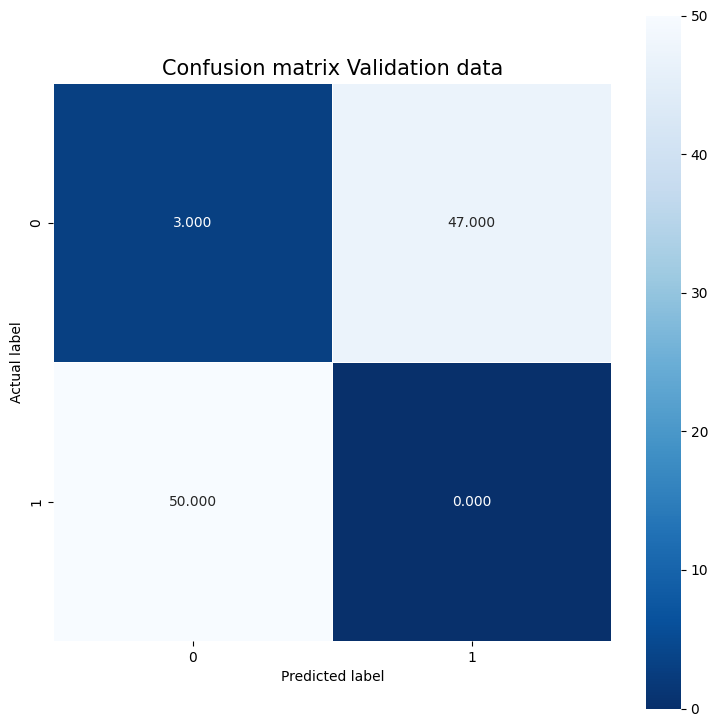

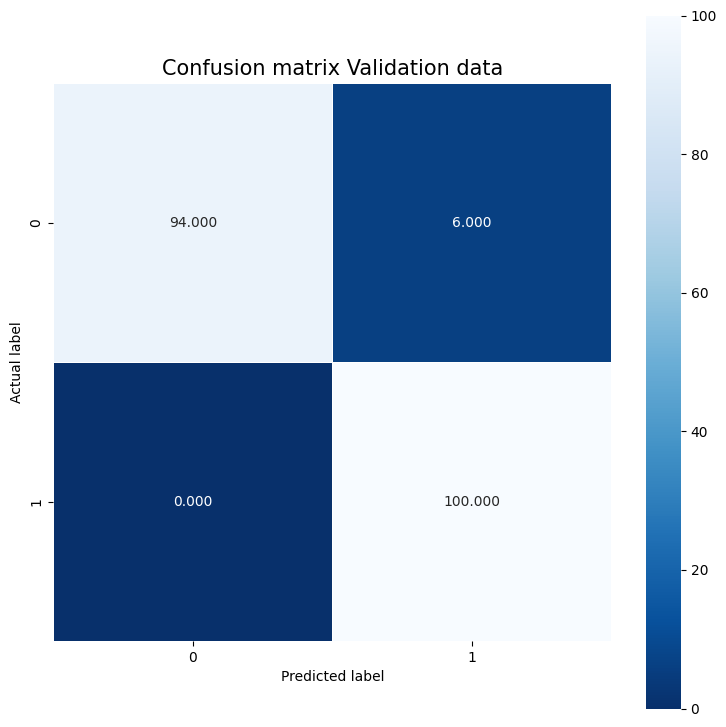

In [ ]:
def LR(Xtrain,Ytrain,Xval,Yval):
  print("--------Logistic Regression--------\n")
  #Define Logistic Regression Classifier
  clf = LogisticRegression(random_state=0,max_iter=10000 )
  #train the classifier
  clf.fit(Xtrain,Ytrain)
  #Calculate accuracy of the model using validation set
  print("Accuracy Train set",clf.score(Xtrain,Ytrain)*100)
  #Calculate accuracy of the model using validation set
  print("Accuracy Valid set",clf.score(Xval,Yval)*100)
  #plot confusion matrix
  get_confusion_matrix(clf,Xval,Yval,"Validation")


# Compute and check the classifier for dataset #0:
#Classify HOG features
print("-------- dataset #0--------\n")
LR(Xtrain_d0,Ytrain_d0,Xval_d0,Yval_d0)

# Compute and check the classifier for dataset #1 :
#Classify HOG features
print("-------- dataset #1--------\n")
LR(Xtrain_d1,Ytrain_d1,Xval_d1,Yval_d1)


###Support Vector Machine###

In [ ]:
def SVM(Xtrain,Ytrain,Xval,Yval):
  print("--------Support Vector Machine--------\n")
  #Define SVM Classifier
  clf = SVC(random_state=0)
  #train the classifier
  clf.fit(Xtrain,Ytrain)
  #Calculate accuracy of the model using validation set
  print("Accuracy Train set",clf.score(Xtrain,Ytrain)*100)
  #Calculate accuracy of the model using validation set
  print("Accuracy Valid set",clf.score(Xval,Yval)*100)
  #plot confusion matrix
  get_confusion_matrix(clf,Xval,Yval,"Validation")

# Compute and check the classifier for dataset #0:
print("-------- dataset #0--------\n")
SVM(Xtrain_d0,Ytrain_d0,Xval_d0,Yval_d0)

# Compute and check the classifier for dataset #1:
print("-------- dataset #1--------\n")
SVM(Xtrain_d1,Ytrain_d1,Xval_d1,Yval_d1)

###Random Forest###

In [ ]:
def RF(Xtrain,Ytrain,Xval,Yval):
  print("--------Random Forest--------\n")
  #Define RF Classifier
  clf = RandomForestClassifier(random_state=0)
  #train the classifier
  clf.fit(Xtrain,Ytrain)
  #Calculate accuracy of the model using validation set
  print("Accuracy Train set",clf.score(Xtrain,Ytrain)*100)
  #Calculate accuracy of the model using validation set
  print("Accuracy Valid set",clf.score(Xval,Yval)*100)
  #plot confusion matrix
  get_confusion_matrix(clf,Xval,Yval,"Validation")

# Compute and check the classifier for dataset #0:
print("-------- dataset #0--------\n")
RF(Xtrain_d0,Ytrain_d0,Xval_d0,Yval_d0)

# Compute and check the classifier for dataset #1:
print("-------- dataset #1--------\n")
RF(Xtrain_d1,Ytrain_d1,Xval_d1,Yval_d1)



###XG Boost###

In [ ]:
def XGBoost(Xtrain,Ytrain,Xval,Yval):
  print("--------XG Boost--------\n")
  #Define XGBoost Classifier
  clf = xgb.XGBClassifier(objective="binary:logistic", random_state=0)
  #train the classifier
  clf.fit(Xtrain,Ytrain)
  #Calculate accuracy of the model using validation set
  print("Accuracy Train set",clf.score(Xtrain,Ytrain)*100)
  #Calculate accuracy of the model using validation set
  print("Accuracy Valid set",clf.score(Xval,Yval)*100)
  #plot confusion matrix
  get_confusion_matrix(clf,Xval,Yval,"Validation")

# Compute and check the classifier for dataset #0:
print("-------- dataset #0--------\n")
XGBoost(Xtrain_d0,Ytrain_d0,Xval_d0,Yval_d0)

# Compute and check the classifier for dataset #1:
print("-------- dataset #1--------\n")
XGBoost(Xtrain_d1,Ytrain_d1,Xval_d1,Yval_d1)


### Model Improvement###
Now with your knowledge from previous labs, modify the hyperparameters of LR and SVM, if needed, and train the models again until you are happy with the validation accuracy wrt the training accuracy.
Afterwards, test the final models (with the chosen hyperparameters) using the test set.


Initially the function is changed to compute the test accuracy as well, and it was considered that we will not look at it during hyperparameter tuning.
But just to avoid any bias due to test accuract, we compute the test accuracy after hyperparameter tunings so we do not see this test accuracy until after we are done.


#### LR


 -------- dataset #0--------

--------Logistic Regression--------

Accuracy Train set 100.0
Accuracy Valid set 3.0

 -------- dataset #1--------

--------Logistic Regression--------

Accuracy Train set 98.3
Accuracy Valid set 97.0


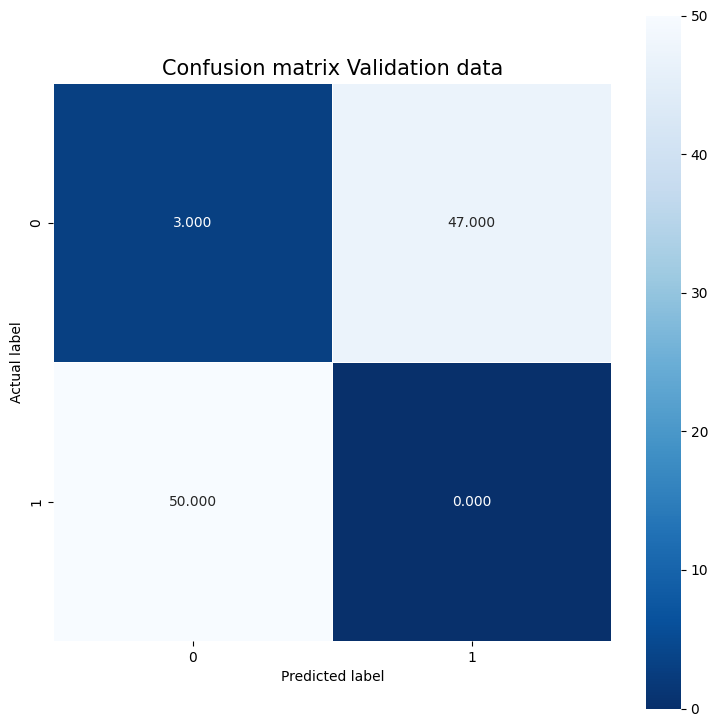

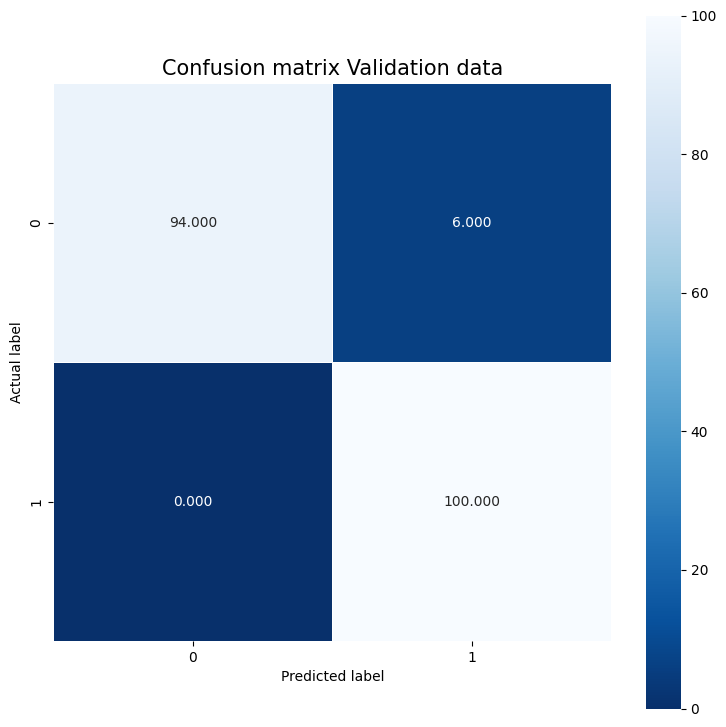

In [ ]:
def LR(Xtrain,Ytrain,Xval,Yval,Xtest,Ytest):
  print("--------Logistic Regression--------\n")
  #Define Logistic Regression Classifier
  clf = LogisticRegression(random_state=0,max_iter=10000 )
  #train the classifier
  clf.fit(Xtrain,Ytrain)
  #Calculate accuracy of the model using validation set
  print("Accuracy Train set",clf.score(Xtrain,Ytrain)*100)
  #Calculate accuracy of the model using validation set
  print("Accuracy Valid set",clf.score(Xval,Yval)*100)

  #plot confusion matrix
  get_confusion_matrix(clf,Xval,Yval,"Validation")




# Compute and check the classifier for dataset #0:
#Classify HOG features
print("\n -------- dataset #0--------\n")
LR_model_d0 = LR(Xtrain_d0,Ytrain_d0,Xval_d0,Yval_d0,Xtest_d0,Ytest_d0)

# Compute and check the classifier for dataset #1 :
#Classify HOG features
print("\n -------- dataset #1--------\n")
LR_model_d1 = LR(Xtrain_d1,Ytrain_d1,Xval_d1,Yval_d1,Xtest_d1,Ytest_d1)


#### SVM

In [ ]:
def SVM(Xtrain,Ytrain,Xval,Yval,Xtest,Ytest):
  print("--------Support Vector Machine--------\n")
  #Define SVM Classifier
  clf = SVC(random_state=0)
  #train the classifier
  clf.fit(Xtrain,Ytrain)
  #Calculate accuracy of the model using validation set
  print("Accuracy Train set",clf.score(Xtrain,Ytrain)*100)
  #Calculate accuracy of the model using validation set
  print("Accuracy Valid set",clf.score(Xval,Yval)*100)
  #plot confusion matrix
  get_confusion_matrix(clf,Xval,Yval,"Validation")



# Compute and check the classifier for dataset #0:
print("\n-------- dataset #0--------\n")
SVM_model_d0 = SVM(Xtrain_d0,Ytrain_d0,Xval_d0,Yval_d0,Xtest_d0,Ytest_d0)

# Compute and check the classifier for dataset #1:
print("\n-------- dataset #1--------\n")
SVM_model_d1 = SVM(Xtrain_d1,Ytrain_d1,Xval_d1,Yval_d1,Xtest_d1,Ytest_d1)



#### Random Forest

In [ ]:
def RF(Xtrain,Ytrain,Xval,Yval,Xtest,Ytest):
  print("--------Random Forest--------\n")
  #Define RF Classifier
  clf = RandomForestClassifier(random_state=0)
  #train the classifier
  clf.fit(Xtrain,Ytrain)
  #Calculate accuracy of the model using validation set
  print("Accuracy Train set",clf.score(Xtrain,Ytrain)*100)
  #Calculate accuracy of the model using validation set
  print("Accuracy Valid set",clf.score(Xval,Yval)*100)
  #plot confusion matrix
  get_confusion_matrix(clf,Xval,Yval,"Validation")

# Compute and check the classifier for dataset #0:
print("\n-------- dataset #0--------\n")
RF_model_d0 = RF(Xtrain_d0,Ytrain_d0,Xval_d0,Yval_d0,Xtest_d0,Ytest_d0)

# Compute and check the classifier for dataset #1:
print("\n-------- dataset #1--------\n")
RF_model_d1 = RF(Xtrain_d1,Ytrain_d1,Xval_d1,Yval_d1,Xtest_d1,Ytest_d1)


#### XGB

In [ ]:
def XGBoost(Xtrain,Ytrain,Xval,Yval,Xtest,Ytest):
  print("--------XG Boost--------\n")
  #Define XGBoost Classifier
  clf = xgb.XGBClassifier(objective="binary:logistic", random_state=0)
  #train the classifier
  clf.fit(Xtrain,Ytrain)
  #Calculate accuracy of the model using validation set
  print("Accuracy Train set",clf.score(Xtrain,Ytrain)*100)
  #Calculate accuracy of the model using validation set
  print("Accuracy Valid set",clf.score(Xval,Yval)*100)
  #plot confusion matrix
  get_confusion_matrix(clf,Xval,Yval,"Validation")


# Compute and check the classifier for dataset #0:
print("\n-------- dataset #0--------\n")
XGB_model_d0 = XGBoost(Xtrain_d0,Ytrain_d0,Xval_d0,Yval_d0,Xtest_d0,Ytest_d0)

# Compute and check the classifier for dataset #1:
print("\n-------- dataset #1--------\n")
XGB_model_d1 = XGBoost(Xtrain_d1,Ytrain_d1,Xval_d1,Yval_d1,Xtest_d1,Ytest_d1)



Now compute Test accuracies for each of the Models after tuning the hyperparameters. **bold text**


In [ ]:
# Compute Test Accuracies for dataset 00 here

In [ ]:
# Compute Test Accuracies for dataset 01 here


**What observations can you make for each of the model? Which one do you think doesnt perform so well?**

## Questions
Once you have your code implemented, answer these questions:


- About `linear_model.LogisticRegression()`: <br>
  - Use the default values of HOG features, and load the “200-100-100” dataset.a Using the `linear_model.LogisticRegression()`, what accuracy do you have predicting the validation and test classes? Show the confusion matrix and the accuracy and compare them. Why are the accuracy of the validation and the test predictions quite different?  (Hint: Analyse the image sets of the “200-100-100” dataset visually) <br>
  - Using now the “10000-2000-2000” dataset, answer again the previous question. Is the result better than the previous one? Why? <br>
  (add your colde for dataset #2 below)

-	`About svm.SVC()`:
  -	Using the default values of HOG features, “1000-200-200” dataset and `svm.SVC()`, what accuracy do you have predicting the validation and test classes?
  -	Using now the “10000-2000-2000” dataset, answer again the previous question.

- About  `ensemble.RandomForestClassifier()`:
  - Using the default values of HOG features, “1000-200-200” dataset and `ensemble.RandomForestClassifier()`, what accuracy do you have predicting the validation and test classes? Show the confusion matrix and the accuracy and compare them.
  - Using now the “10000-2000-2000” dataset, answer again the previous question.


- About `XGBClassifier()`:
   - Using the default values of HOG features, “1000-200-200” dataset and `XGBClassifier()`, what accuracy do you have predicting the validation and test classes? Show the confusion matrix and the accuracy and compare them.
  - Using now the “10000-2000-2000” dataset, answer again the previous question.


-	Compare the results obtained with each classifier with both datasets and each feature extraction method and choose the best combination and explain why you chose it.

## Deliverable ##
You must deliver this notebook with all the cells executed and the questions answered (in red).